Using v2 dataset. 80/20 split, no separate test.

In [1]:
from pathlib import Path

# import * appears to be the fast.ai way of doing things,
# even though every instinct in me says "don't do this" :)
from fastai.vision import *  
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

In [2]:
path = Path("~/data/split-v2-random").expanduser()

In [ ]:
data = ImageDataBunch.from_folder(path, bs=32)

It seems to be already normalized (check with `data.one_batch(DatasetType.Train)`)

This loads a model with pretrained weights (imagenet?), custom head, everything is frozen apart from the head.

In [ ]:
learn = cnn_learner(data, models.resnet18, metrics=accuracy, ps=.6)

Dropout control with `ps`, default is .5.
I think it is like keras: the probability to zero out inputs.

In [7]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


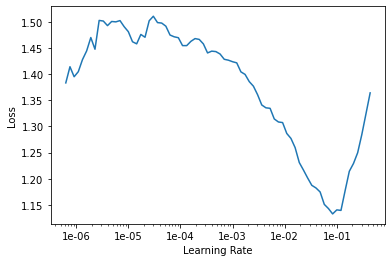

In [8]:
learn.recorder.plot()

In [38]:
learn.fit_one_cycle(5, 0.02)

epoch,train_loss,valid_loss,accuracy,time
0,0.409558,2.838449,0.576279,12:07
1,0.280344,0.331535,0.880930,12:09
2,0.156675,0.108098,0.963721,12:07
3,0.066581,0.033917,0.989302,12:07
4,0.042252,0.037278,0.988837,12:07


In [39]:
learn.save("model-fastai-2-random-5epochs")

Try to continue a bit longer; it was still improving quite a bit!

In [40]:
learn.fit_one_cycle(2, 0.02)

epoch,train_loss,valid_loss,accuracy,time
0,0.224678,0.105331,0.954884,12:04
1,0.061017,0.036272,0.988372,12:04


Diverged in very first epoch. LR needs to be lower probably. Let's revert and try to unfreeze the first part before proceeding:

In [5]:
learn.load("model-fastai-2-random-5epochs")
learn.unfreeze()

In [6]:
# Batch size needs to be a bit lower now that there's more layers to train:
learn.data.batch_size = 28

In [7]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


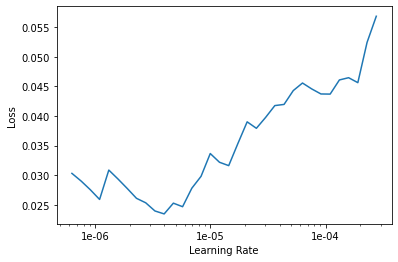

In [8]:
learn.recorder.plot()

We seem to have settled into a (local) minimum. Training more with a high LR doesn't seem to have much more sense, as we have seen.

Things to try:
1. Fit a few more epochs with a very low learning rate
2. Try unfreezing earlier, e.g. from the third epoch onward.

Will try #1 first:

In [16]:
learn.fit_one_cycle(2, max_lr=[1e-7, 1e-6, 2e-6])

epoch,train_loss,valid_loss,accuracy,time
0,0.032608,0.029758,0.990698,14:07
1,0.036219,0.027987,0.990698,14:03


In [17]:
learn.save("model-fastai-2-random-5epochs-plus2unfrozen")

### Restart from scratch, unfreezing earlier.

In [18]:
learn = cnn_learner(data, models.resnet18, metrics=accuracy, ps=.6)

In [19]:
learn.fit_one_cycle(2, 0.02)

epoch,train_loss,valid_loss,accuracy,time
0,0.366409,0.970967,0.855814,10:29
1,0.108255,0.049316,0.981395,10:28


Oof, this second epoch turned out much better than the first run. It may already be too far down in the problem landscape to get a strong signal for updating the earlier layers.

In [20]:
learn.save("model-fastai-2-random-2epochs")

In [21]:
learn.unfreeze()
learn.data.batch_size = 28
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


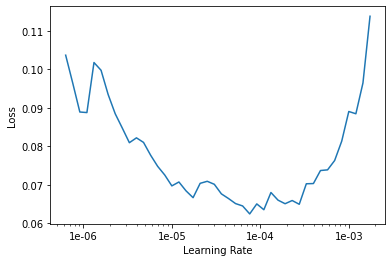

In [22]:
learn.recorder.plot()

In [23]:
learn.fit_one_cycle(2, max_lr=[2e-6, 1e-5, 4e-5])

epoch,train_loss,valid_loss,accuracy,time
0,0.061612,0.034875,0.988372,14:03
1,0.056074,0.033235,0.991628,14:04


In [24]:
learn.save("model-fastai-2-random-2epochs-plus2unfrozen")

In [25]:
learn.fit_one_cycle(1, max_lr=[2e-6, 1e-5, 4e-5])

epoch,train_loss,valid_loss,accuracy,time
0,0.042122,0.028744,0.991628,14:02


In [26]:
learn.save("model-fastai-2-random-2epochs-plus3unfrozen")

### choose and proceed
Let's continue with the last one.

In [27]:
pred_train = learn.get_preds(ds_type=DatasetType.Train)

In [28]:
accuracy(*pred_train)

tensor(0.9951)

In [ ]:
pred_cv = learn.get_preds(ds_type=DatasetType.Valid)

In [30]:
accuracy(*pred_cv)

tensor(0.9916)

In [76]:
def sklearn_metrics(preds_output):
    preds, labels = preds_output
    pred_classes = (preds > .5).numpy().astype(int)[:, 1]
    
    acc = accuracy_score(labels, pred_classes)
    prec = precision_score(labels, pred_classes)
    recall = recall_score(labels, pred_classes)
    f1 = 2 * prec * recall / (prec + recall)

    print(f"Accuracy:  {acc:.3f}")  # Sanity check
    print(f"Precision: {prec:.3f}")
    print(f"Recall:    {recall:.3f}")
    print(f"F1:        {f1:.3f}")

In [77]:
sklearn_metrics(pred_train)

Accuracy:  0.995
Precision: 0.989
Recall:    0.980
F1:        0.984


In [79]:
sklearn_metrics(pred_cv)

Accuracy:  0.992
Precision: 0.971
Recall:    0.976
F1:        0.974


# Very impressive!
Only problem now is that I am unsure if this generalizes to *truly* data... I fear a bit that the random split is causing the metrics to be too optimistic. I will have to re-do this for a time series split.